# Importación de librerías
A continuación, se importan las librerías a utilizar en el notebook

In [2]:
# Librerías de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Librerías de SciKit Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Procesamiento de imágenes
import skimage
from skimage.transform import resize
import cv2

# Utilidades generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import os
import zipfile
import pickle

# Google Colab
import gdown

# Limpieza de memoria
import gc

In [3]:
RANDOM_SEED = 42
SAMPLE_SIZE = 0.95
VAL_SIZE = 0.5

# Descarga de dataset
Se utilizarán diferentes datasets para el entrenamiento/validación y las pruebas

Dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

Cargar archivos de Google Drive

In [4]:
#gdown.download('https://drive.google.com/uc?id=1VM68wfY1XJXsLAVvZ1dru2840iE_HDRp', quiet=False) # dataset v2
gdown.download('https://drive.google.com/uc?id=1A2HJnCGaO-ta7pBAE7l2aJR79tD2zD3h', quiet=False) # dataset v1
#gdown.download('https://drive.google.com/uc?id=1K3KSWVCoogKVBQGBPuFDV-Dvx6bbueBw', quiet=False) # encoder entrenado
#gdown.download('https://drive.google.com/uc?id=1LIF6h8GFLsZnsr7eoSe1evfWX7KWTI6L', quiet=False) # modelo entrenado

Downloading...
From (original): https://drive.google.com/uc?id=1A2HJnCGaO-ta7pBAE7l2aJR79tD2zD3h
From (redirected): https://drive.google.com/uc?id=1A2HJnCGaO-ta7pBAE7l2aJR79tD2zD3h&confirm=t&uuid=d2b9ba44-171e-42c3-9719-1a6380db6bf2
To: /content/covid_v1.zip
100%|██████████| 758M/758M [00:11<00:00, 65.8MB/s]


'covid_v1.zip'

In [5]:
fileTrainVal = 'covid_v1.zip'
folderTrainVal = './trainval'

In [6]:
with zipfile.ZipFile(fileTrainVal, 'r') as zip_ref:
  zip_ref.extractall(folderTrainVal)

El 95% del dataset se utilizará para entrenamiento y validación. El 5% restante para pruebas

In [7]:
# Obtener la lista de rutas de las imágenes en las carpetas "normal" y "covid"
normal_folder = os.path.join(folderTrainVal, 'dataset/normal')
covid_folder = os.path.join(folderTrainVal, 'dataset/covid')

full_normal_paths = [os.path.join(normal_folder, filename) for filename in os.listdir(normal_folder)]
full_covid_paths = [os.path.join(covid_folder, filename) for filename in os.listdir(covid_folder)]

In [8]:
print("Normales imágenes:", len(full_normal_paths))
print('Covid imágenes:', len(full_covid_paths))
print('Total imágenes:', len(full_normal_paths) + len(full_covid_paths))

Normales imágenes: 1366
Covid imágenes: 290
Total imágenes: 1656


In [9]:
random.seed(RANDOM_SEED)

sample_size = int(len(full_normal_paths) * SAMPLE_SIZE)
normal_paths = random.sample(full_normal_paths, sample_size)

sample_size = int(len(full_covid_paths) * SAMPLE_SIZE)
covid_paths = random.sample(full_covid_paths, sample_size)

In [10]:
print("Normales imágenes:", len(normal_paths))
print('Covid imágenes:', len(covid_paths))
print('Total imágenes:', len(normal_paths) + len(covid_paths))

Normales imágenes: 1297
Covid imágenes: 275
Total imágenes: 1572


Funciones auxiliares

In [11]:
# Función para procesar las imágenes
def process_images(image_paths, label):
  data = []
  labels = []
  for image_path in image_paths:
    # Leer la imagen
    image = cv2.imread(image_path)
    # Convertir la imagen a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar la imagen a 224x224 píxeles
    image = cv2.resize(image, (224, 224))
    # Normalizar los valores de píxeles
    image = image / 255.0
    # Agregar la imagen y su etiqueta a las listas de datos y etiquetas
    data.append(image)
    labels.append(label)
  return data, labels

In [12]:
# función auxiliar para graficar el reporte
def mostrar_df_estilizado(df):
  styled_df = df.style\
    .set_properties(**{'text-align': 'center', 'font-size': '10pt'})\
    .set_properties(subset=pd.IndexSlice[:, df.select_dtypes(include=[object]).columns],
      **{'background-color': 'white', 'color': 'black'})\
    .set_properties(**{'background-color': 'white', 'color': 'black'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'),('background-color', '#f4f4f4'),('color', 'black')]}])\
    .format(precision=4)
  return styled_df

In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (5,4), fontsize=10):
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
  fig = plt.figure(figsize=figsize)
  try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='crest')
  except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  print(fig)

# Carga de datos en memoria
Aprox 10GB de RAM, dirigirse al a sección Pruebas si ya se tiene el modelo descargado y no se desea entrenar

In [14]:
normal_data, normal_labels = process_images(normal_paths, label='normal')
covid_data, covid_labels = process_images(covid_paths, label='covid')

# Combinar los datos y las etiquetas de las dos clases
data = np.concatenate([normal_data, covid_data], axis=0)
labels = np.concatenate([normal_labels, covid_labels], axis=0)

# Mostrar la forma de los datos y las etiquetas
print("Forma de los datos:", data.shape)
print("Forma de las etiquetas:", labels.shape)

Forma de los datos: (1572, 224, 224, 3)
Forma de las etiquetas: (1572,)


In [15]:
# Limpieza de memoria
normal_data = []
covid_data = []
normal_labels = []
covid_labels = []
gc.collect()

0

In [16]:
# Codificar etiquetas en valores enteros
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

class_names = label_encoder.classes_.tolist()
class_names

['covid', 'normal']

In [17]:
# Guardar encoder
with open('label_encoder.pkl', 'wb') as f:
  pickle.dump(label_encoder, f)

In [18]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_one_hot,test_size=VAL_SIZE, stratify=labels_one_hot, random_state=RANDOM_SEED)

# Diseño de la red


Fuente: https://ijeecs.iaescore.com/index.php/IJEECS/article/view/27057/16119

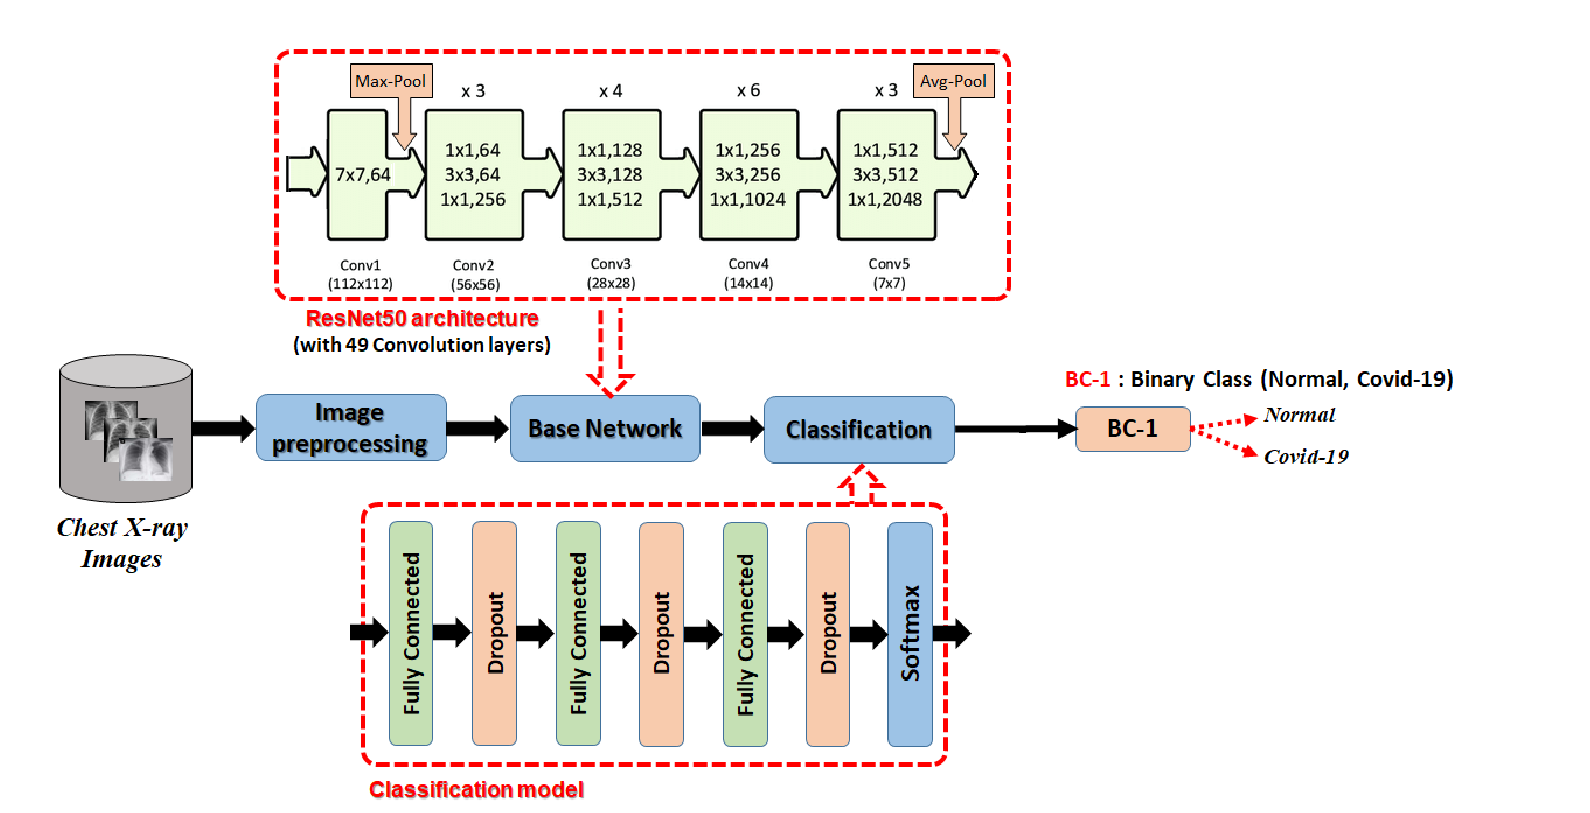

In [19]:
# Obtener la forma de los datos
input_shape = data[0].shape

# Definir la red base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar el modelo base
for layer in base_model.layers:
    layer.trainable = False

# Obtener el output de RestNet
base_output = base_model.output

# Diseñar capas ocultas
fc = Flatten()(base_output)
fc = Dropout(0.12)(fc)
fc = Dense(200, kernel_initializer=he_uniform())(fc)
fc = Activation('relu')(fc)
fc = Dropout(0.2)(fc)
fc = Dense(300, kernel_initializer=he_uniform())(fc)
fc = Activation('relu')(fc)
fc = Dropout(0.15)(fc)

# Diseñar última capa
output_layer = Dense(2, activation='softmax')(fc)

# Armar el modelo
model_mvg = Model(inputs=base_model.input, outputs=output_layer)

# Compilar el moedlo
optimizer = Adam(learning_rate=0.0001)
model_mvg.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Imprimir el modelo
model_mvg.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

# Entrenamiento
A continuación, se realizará el entrenamiento del modelo

In [20]:
NUM_EPOCHS = 35
BATCH_SIZE = 25
PATIENCE = 5

In [21]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')
checkpoint = ModelCheckpoint('best_model_mvg.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

In [22]:
# Train the model
history = model_mvg.fit(X_train, Y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint]) # se quitó el early stopping porque tenemos GPU

Epoch 1/35
32/32 [==============================] - 18s 309ms/step - loss: 0.5081 - accuracy: 0.8142 - val_loss: 0.3068 - val_accuracy: 0.8257
Epoch 2/35
32/32 [==============================] - 6s 203ms/step - loss: 0.2974 - accuracy: 0.8690 - val_loss: 0.1850 - val_accuracy: 0.9466
Epoch 3/35
32/32 [==============================] - 6s 206ms/step - loss: 0.1961 - accuracy: 0.9288 - val_loss: 0.1324 - val_accuracy: 0.9720
Epoch 4/35
32/32 [==============================] - 5s 147ms/step - loss: 0.1545 - accuracy: 0.9504 - val_loss: 0.1735 - val_accuracy: 0.9313
Epoch 5/35
32/32 [==============================] - 7s 213ms/step - loss: 0.1333 - accuracy: 0.9542 - val_loss: 0.1032 - val_accuracy: 0.9733
Epoch 6/35
32/32 [==============================] - 5s 148ms/step - loss: 0.1268 - accuracy: 0.9555 - val_loss: 0.1033 - val_accuracy: 0.9695
Epoch 7/35
32/32 [==============================] - 5s 148ms/step - loss: 0.1000 - accuracy: 0.9669 - val_loss: 0.0840 - val_accuracy: 0.9733
Epoch

In [23]:
gc.collect()

1354

# Evaluación
Se carga el mejor modelo por val_loss

In [24]:
# Cargar el modelo entrenado desde el archivo guardado
best_model_mvg = load_model("best_model_mvg.keras")
best_epoch = np.argmax(history.history['val_accuracy'])

Se grafican las curvas de la historia del entrenamiento

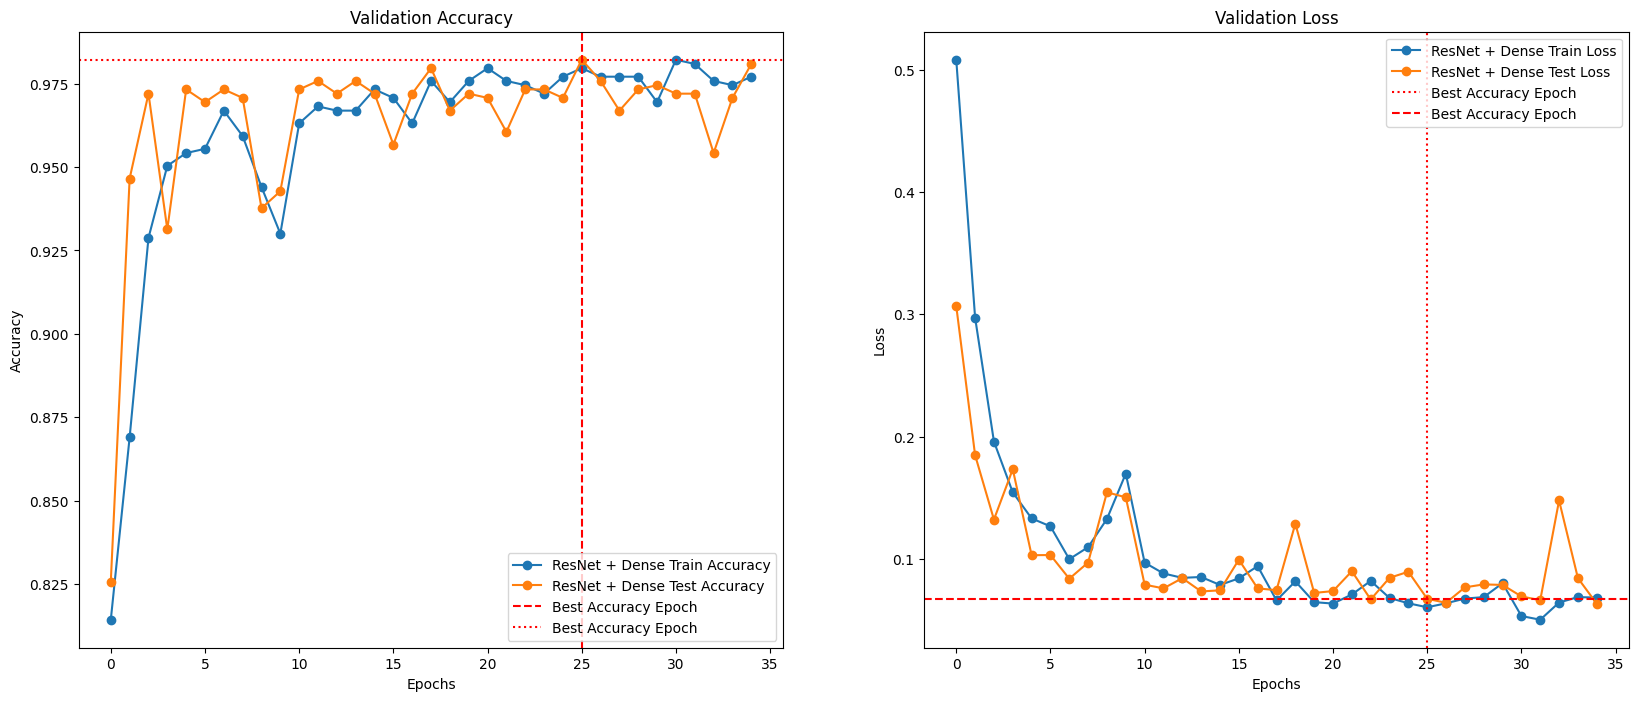

In [25]:
epochs_range = range(NUM_EPOCHS)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, '-o', label='ResNet + Dense Train Accuracy')
plt.plot(epochs_range, val_acc, '-o', label='ResNet + Dense Test Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Accuracy Epoch')
plt.axhline(y=val_acc[best_epoch], color='r', linestyle=':', label='Best Accuracy Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, '-o', label='ResNet + Dense Train Loss')
plt.plot(epochs_range, val_loss, '-o', label='ResNet + Dense Test Loss')
plt.axvline(x=best_epoch, color='r', linestyle=':', label='Best Accuracy Epoch')
plt.axhline(y=val_loss[best_epoch], color='r', linestyle='--', label='Best Accuracy Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

Se muestra el reporte de clasificación

In [26]:
Y_pred = best_model_mvg.predict(X_val)

25/25 [==============================] - 6s 147ms/step


In [27]:
cr = classification_report(Y_val.argmax(axis=1), Y_pred.argmax(axis=1),target_names=class_names,output_dict=True)
mostrar_df_estilizado(pd.DataFrame(cr))

,covid,normal,accuracy,macro avg,weighted avg
precision,0.9767,0.9833,0.9822,0.9800,0.9821
recall,0.9197,0.9954,0.9822,0.9575,0.9822
f1-score,0.9474,0.9893,0.9822,0.9683,0.9820
support,137.0000,649.0000,0.9822,786.0000,786.0000


Se muestra la matriz de confusión

In [28]:
cm = confusion_matrix(Y_val.argmax(axis=1), Y_pred.argmax(axis=1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("acc: {:.2f}%".format(acc*100))
print("sensitivity: {:.2f}%".format(sensitivity*100))
print("specificity: {:.2f}%".format(specificity*100))

acc: 98.22%
sensitivity: 91.97%
specificity: 99.54%


Figure(500x400)


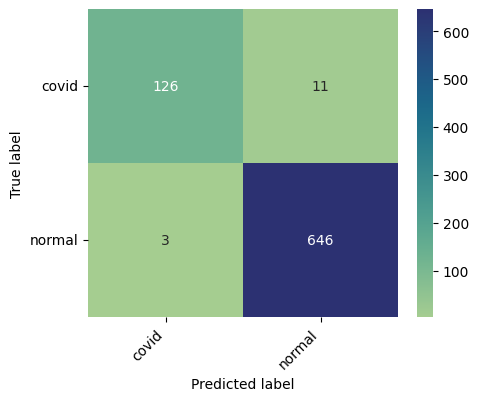

In [29]:
print_confusion_matrix(cm,class_names)

# Pruebas
Se realizará la prueba del modelo en el 30% restante del dataset

In [30]:
# Fija la semilla aleatoria para replicabilidad
random.seed(RANDOM_SEED)

# Obtén la muestra del 70%
sample_size_normal = int(len(full_normal_paths) * SAMPLE_SIZE)
normal_paths_sample = random.sample(full_normal_paths, sample_size_normal)

sample_size_covid = int(len(full_covid_paths) * SAMPLE_SIZE)
covid_paths_sample = random.sample(full_covid_paths, sample_size_covid)

# Obtén el 30% restante
normal_paths_test = [path for path in full_normal_paths if path not in normal_paths_sample]
covid_paths_test = [path for path in full_covid_paths if path not in covid_paths_sample]

In [31]:
print("Normales imágenes:", len(normal_paths_test))
print('Covid imágenes:', len(covid_paths_test))
print('Total imágenes:', len(normal_paths_test) + len(covid_paths_test))

Normales imágenes: 69
Covid imágenes: 15
Total imágenes: 84


In [32]:
data = []
labels = []
gc.collect()

14595

In [33]:
normal_data_test, normal_labels_test = process_images(normal_paths_test, label='normal')
covid_data_test, covid_labels_test = process_images(covid_paths_test, label='covid')

# Combinar los datos y las etiquetas de las dos clases
data = np.concatenate([normal_data_test, covid_data_test], axis=0)
labels = np.concatenate([normal_labels_test, covid_labels_test], axis=0)

# Mostrar la forma de los datos y las etiquetas
print("Forma de los datos:", data.shape)
print("Forma de las etiquetas:", labels.shape)

Forma de los datos: (84, 224, 224, 3)
Forma de las etiquetas: (84,)


In [34]:
# Liberar memoria
normal_data_test = []
covid_data_test = []
normal_labels_test = []
covid_labels_test = []
gc.collect()

0

In [35]:
# Cargar encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [36]:
# Codificar etiquetas en valores enteros
labels_encoded = label_encoder.transform(labels)
Y_test = to_categorical(labels_encoded)

class_names = label_encoder.classes_.tolist()
class_names

['covid', 'normal']

In [37]:
# Cargar el modelo entrenado desde el archivo guardado
best_model_mvg = load_model("best_model_mvg.keras")
Y_pred = best_model_mvg.predict(data)

3/3 [==============================] - 3s 881ms/step


In [38]:
cr = classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1),target_names=class_names,output_dict=True)
mostrar_df_estilizado(pd.DataFrame(cr))

,covid,normal,accuracy,macro avg,weighted avg
precision,0.8750,0.9853,0.9643,0.9301,0.9656
recall,0.9333,0.9710,0.9643,0.9522,0.9643
f1-score,0.9032,0.9781,0.9643,0.9407,0.9647
support,15.0000,69.0000,0.9643,84.0000,84.0000


In [39]:
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("acc: {:.2f}%".format(acc*100))
print("sensitivity: {:.2f}%".format(sensitivity*100))
print("specificity: {:.2f}%".format(specificity*100))

acc: 96.43%
sensitivity: 93.33%
specificity: 97.10%


Figure(500x400)


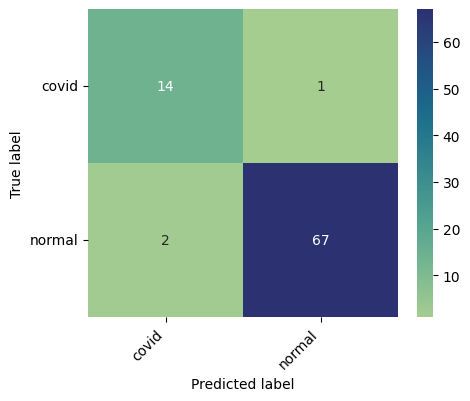

In [40]:
print_confusion_matrix(cm,class_names)